<a href="https://colab.research.google.com/github/kushalnavghare/DSC-478_PRG_ML_APP/blob/main/Assignment_2_DSC_478.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
## Name: Kushal Navghare
## Student ID: 2116916

For this assignment you will experiment with various classification models using subsets of some real-world data sets. In particular, you will use the K-Nearest-Neighbor algorithm to classify text documents, experiment with and compare classifiers that are part of the scikit-learn machine learning package for Python, and use some additional preprocessing capabilities of pandas and scikit-learn packages.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/DSC-478_PRG_ML_APPS

/content/drive/MyDrive/DSC-478_PRG_ML_APPS


In [3]:

%pwd

'/content/drive/MyDrive/DSC-478_PRG_ML_APPS'

# 1.	K-Nearest-Neighbor (KNN) classification on Newsgroups [Dataset: [newsgroups.zip](https://http://facweb.cs.depaul.edu/mobasher/classes/CSC478/Data/newsgroups.zip)]

Your tasks in this problem are the following [Note: for this problem you should not use scikit-learn for classification, but implement your own KNN classifier. You may use Pandas, NumPy, standard Python libraries, and Matplotlib.]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [5]:
import warnings
warnings.filterwarnings(action='ignore')

## a
Load the data sets, including the train and test matrices as well as the train and test labels. Show the top 20 terms in the decreasing order of total training frequency (total number of occurences of the term across all documents in the training data). Then plot the distribtution of term frequencies in the training data (using a line plot similar to class examples).



In [6]:
# read the data
raw_train_matrix = pd.read_table('data/trainMatrixModified.txt', header=None)
raw_test_matrix = pd.read_table('data/testMatrixModified.txt', header=None)

# labels
train_labels = pd.read_table('data/trainClasses.txt', header=None)
test_labels = pd.read_table('data/testClasses.txt', header=None)

# headers
headers = pd.read_table('data/modifiedterms.txt', header=None)

In [8]:
# shape of labels
len(train_labels), len(test_labels)

(800, 200)

In [9]:
# shape of dataset
len(raw_train_matrix), len(raw_test_matrix)

(5500, 5500)

In [10]:
# # we'll assign words to row index
raw_train_matrix.index = headers[0]
raw_test_matrix.index = headers[0]

In [11]:
raw_train_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,,,,,,,,,,,,,,,,,,,,,
david,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rex,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wood,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
subject,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
call,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [135]:
# get top 20 terms occuring across all documents
top_20_train_terms = raw_train_matrix.sum(axis=1).sort_values(0, ascending=False).head(20)
top_20_test_terms = raw_test_matrix.sum(axis=1).sort_values(0, ascending=False).head(20)
print(top_20_train_terms.head())
print(top_20_test_terms.head())

0
subject    959.0
window     720.0
game       680.0
do         578.0
get        545.0
dtype: float64
0
file       264.0
subject    251.0
25         221.0
program    186.0
get        182.0
dtype: float64


Text(0.5, 1.0, 'Distribtution of term frequencies in the training data')

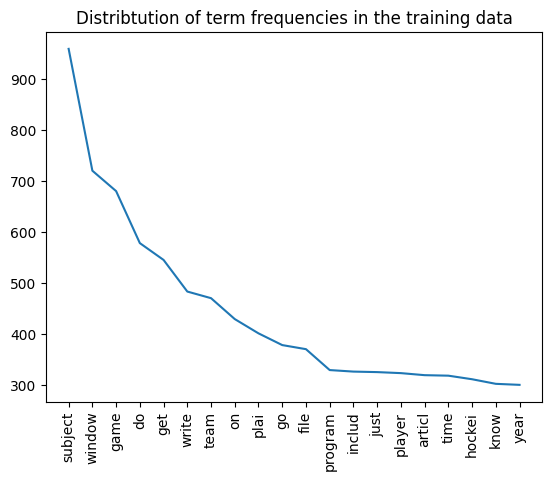

In [133]:
plt.plot(top_20_train_terms.index, sorted(top_20_train_terms, reverse=True))
plt.xticks(rotation=90)
plt.title("Distribtution of term frequencies in the training data")

Text(0.5, 1.0, 'Distribtution of term frequencies in the test data')

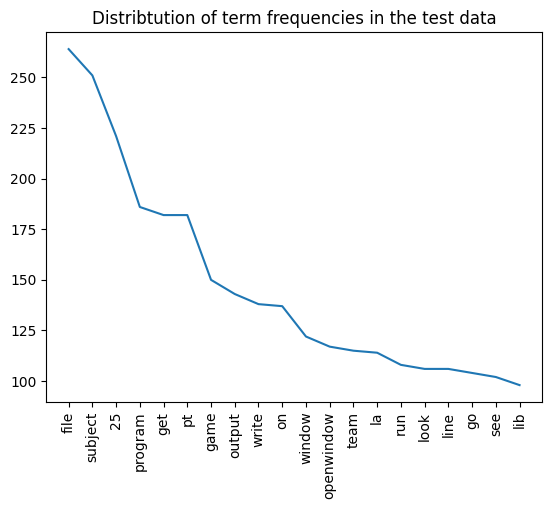

In [134]:
plt.plot(top_20_test_terms.index, sorted(top_20_test_terms, reverse=True))
plt.xticks(rotation=90)
plt.title("Distribtution of term frequencies in the test data")

## b.
Create your own K-Nearest-Neighbor classifier function. Your classifier should allow as input the training data matrix, the training labels, the instance to be classified, the value of K (number of neighbors), and should return the predicted class for the instance and the indices of the top K neighbors. Your classifier should work with Euclidean distance as well as Cosine distance (which is 1 minus the Cosine similarity). You may create two separate classifiers, or add the distance metric as a parameter in the classifier function (an example implementation of a KNN classifier was provided in class examples). Show that your classifier works by running it on the first two instances in the test data using both Cosine and Euclidean distance in each case.

In [15]:
# convert to numpy array
train_matrix = np.array(raw_train_matrix.T)
test_matrix = np.array(raw_test_matrix.T)

In [16]:
# shape of matrix
train_matrix.shape, test_matrix.shape

((800, 5500), (200, 5500))

In [17]:
# custom KNN search function
def knn_search(x, D, K, measure):
    """ find K nearest neighbors of an instance x among the instances in D """
    if measure == 0:
        # euclidean distances from the other points
        dists = np.sqrt(((D - x)**2).sum(axis=1))
    elif measure == 1:
        # first find the vector norm for each instance in D as wel as the norm for vector x
        D_norm = np.array([np.linalg.norm(D[i]) for i in range(len(D))])
        x_norm = np.linalg.norm(x)
        # Compute Cosine: divide the dot product o x and each instance in D by the product of the two norms
        sims = np.dot(D,x)/(D_norm * x_norm)
        # The distance measure will be the inverse of Cosine similarity
        dists = 1 - sims
    idx = np.argsort(dists) # sorting
    # return the indexes of K nearest neighbors
    return idx[:K], dists

In [18]:
train_matrix[0]

array([2., 2., 2., ..., 0., 0., 0.])

In [19]:
test_matrix[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
train_matrix.shape

(800, 5500)

In [21]:
# test
neigh_idx, distances = knn_search(test_matrix[0], train_matrix, 5, 0)

In [22]:
neigh_idx

array([685, 628, 703, 266, 510])

In [23]:
test_data = test_matrix[:2]

In [24]:
print("Measure: Euclidean")
counter = 0
k_neighbors = 3
for test_instance in test_data:
  counter += 1
  # test
  neigh_idx, distances = knn_search(test_instance, train_matrix, k_neighbors, 0)
  # get labels using mode
  neigh_labels = train_labels[1][neigh_idx].mode()[0]
  print(f"Label for instance {counter} is {k_neighbors} neighbors: {neigh_labels}")

Measure: Euclidean
Label for instance 1 is 3 neighbors: 1
Label for instance 2 is 3 neighbors: 0


In [25]:
print("Measure: Cosine")
counter = 0
k_neighbors = 3
for test_instance in test_data:
  counter += 1
  # test
  neigh_idx, distances = knn_search(test_instance, train_matrix, k_neighbors, 1)
  # get labels using mode
  neigh_labels = train_labels[1][neigh_idx].mode()[0]
  print(f"Label for instance {counter} with {k_neighbors} neighbors is: {neigh_labels}")

Measure: Cosine
Label for instance 1 with 3 neighbors is: 1
Label for instance 2 with 3 neighbors is: 0


## c.
Create an evaluation function to measure the accuracy of your classifier. This function will call the classifier function in part a on all the test instances and in each case compares the actual test class label to the predicted class label. It should take as input the training data, the training labels, the test instances, the labels for test instances, and the value of K. Your evaluation function should return the Classification Accuracy (ratio of correct predictions to the number of test instances) [See class notes: Classification & Prediction - Review of Basic Concepts].



In [26]:
# evaluation function
def evaluationFunction(train_data, train_labels, test_data, test_labels, k_neighbors, measure=0):
  """
    Function to calculate accuracy ratio of knn_search on all test instances
    args:
      train_data: train data matrix
      train_labels: train data labels
      test_data: test data matrix
      test_labels: test data labels
      k_neighbors: number of neighbors
      measure: measure (cosine or euclidean:default is euclidean)
    return:
      acc_ratio: accuracy ratio (correct predictions/total #)
  """

  correct_predictions = 0
  # loop over test instances
  for idx in range(len(test_data)):
    # get test instance and labels
    test_instance = test_data[idx]
    actual_label = test_labels[idx]

    # apply search (custom knn_search function)
    neigh_idx, distances = knn_search(test_instance, train_data, k_neighbors, measure)
    # get labels using mode
    predict_label = train_labels[neigh_idx].mode()[0]

    # check if the prediction is correct
    if predict_label == actual_label:
      correct_predictions += 1

  # get accuracy ratio
  acc_ratio = correct_predictions / len(test_data)

  return acc_ratio

In [27]:
# test accuracy for k=5
k_neighbors = 5
acc_ratio = evaluationFunction(train_data=train_matrix, train_labels=train_labels[1],
                    test_data=test_matrix, test_labels=test_labels[1],
                    k_neighbors=k_neighbors)
print(f"Classification accuracy for k={k_neighbors}: ", acc_ratio)

Classification accuracy for k=5:  0.815


## d.
Run your evaluation function on a range of values for K from 5 to 100 (in increments of 5) in order to compare accuracy values for different numbers of neighbors. Do this both using Euclidean Distance as well as Cosine similarity measure. Present the results as graphs with K in the x-axis and the evaluation metric (accuracy) on the y-axis. Use a single plot to compare the two version of the classifier (Euclidean distance version vs. cosine similarity version).

In [28]:
# define lists to store acc_ratio
euclidean_acc_ratio, cosine_acc_ratio = [], []

# define measures for distance metric
measures = [0, 1]

# loop over measure
for measure in measures:
  # loop over k_neighbors value
  for k_value in range(5, 101, 5):
    if measure == 0:
      euclidean_acc_ratio.append(evaluationFunction(train_data=train_matrix, train_labels=train_labels[1],
                    test_data=test_matrix, test_labels=test_labels[1],
                    k_neighbors=k_value, measure=measure))
    elif measure == 1:
      cosine_acc_ratio.append(evaluationFunction(train_data=train_matrix, train_labels=train_labels[1],
                    test_data=test_matrix, test_labels=test_labels[1],
                    k_neighbors=k_value, measure=measure))

In [29]:
euclidean_acc_ratio[:3]

[0.815, 0.705, 0.785]

In [30]:
cosine_acc_ratio[:3]

[0.97, 0.975, 0.985]

In [31]:
len(euclidean_acc_ratio), len(cosine_acc_ratio)

(20, 20)

Text(0.5, 1.0, 'Classification accuracy over range of k values')

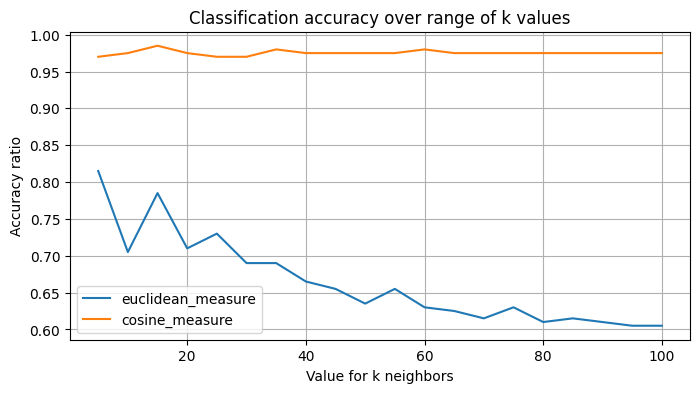

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(range(5, 101, 5), euclidean_acc_ratio, label='euclidean_measure')
plt.plot(range(5, 101, 5), cosine_acc_ratio, label='cosine_measure')
plt.legend()
plt.grid()
plt.xlabel("Value for k neighbors")
plt.ylabel("Accuracy ratio")
plt.title("Classification accuracy over range of k values")

## e
Next, modify the training and test data sets so that term weights are converted to TFxIDF weights (instead of raw term frequencies). [See class notes on Text Categorization]. Then, rerun your evaluation (only for the Cosine similarity version of the classifier) on the range of K values (as above) and create a chart comparing the results with and without using TFxIDF weights.

In [33]:
# we will use standard sklearn methods for tfidf
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [34]:
# initiate tfidf instance
tfidf_vectorizer = TfidfTransformer()

In [35]:
# transform
train_tfidf_matrix = tfidf_vectorizer.fit_transform(train_matrix).toarray()
test_tfidf_matrix = tfidf_vectorizer.fit_transform(test_matrix).toarray()

In [36]:
# # first we'll convert data into tf features
# train_tf_matrix = train_matrix / np.sum(train_matrix, axis=1, keepdims=True)
# test_tf_matrix = test_matrix / np.sum(test_matrix, axis=1, keepdims=True)

In [37]:
# # now, we'll convert tf matrix into idf
# train_idf_matrix = np.log(train_matrix.shape[0] / np.count_nonzero(train_matrix, axis=0))
# test_idf_matrix = np.log(test_matrix.shape[0] / np.count_nonzero(test_matrix, axis=0))

In [38]:
# # now tf-idf matrix
# train_tfidf_matrix = train_tf_matrix * train_idf_matrix
# test_tfidf_matrix = test_tf_matrix * test_idf_matrix

In [39]:
# cosine similarity run with tfidf weights
measure = 1
cosine_tfidf_acc = []
for k_value in range(5, 101, 5):
  cosine_tfidf_acc.append(evaluationFunction(train_data=train_tfidf_matrix, train_labels=train_labels[1],
                      test_data=test_tfidf_matrix, test_labels=test_labels[1],
                      k_neighbors=k_value, measure=measure))

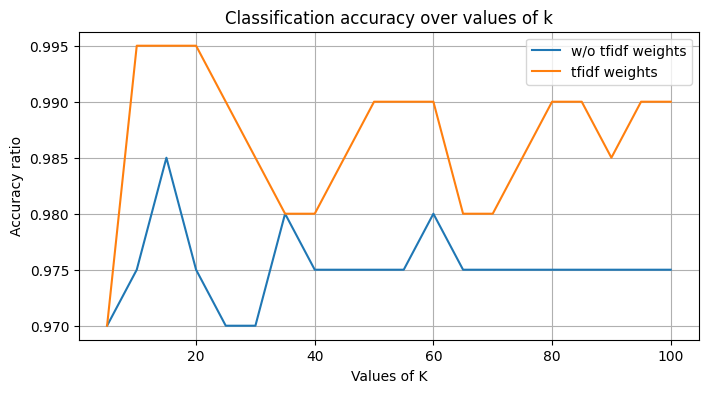

In [40]:
plt.figure(figsize=(8, 4))
plt.plot(range(5, 101, 5), cosine_acc_ratio, label = 'w/o tfidf weights')
plt.plot(range(5, 101, 5), cosine_tfidf_acc, label = 'tfidf weights')
plt.xlabel('Values of K')
plt.ylabel("Accuracy ratio")
plt.title("Classification accuracy over values of k")
plt.grid()
plt.legend()

## f.
Create a new classifier based on the Rocchio Method (also know as the "nearest centroid" method) adapted for text categorization [See class notes on Text Categorization]. You should separate the training function from the classification function. The training part for the classifier can be implemented as a function that takes as input the training data matrix and the training labels, returning the prototype vectors for each class. The classification part can be implemented as another function that would take as input the prototypes returned from the training function and the instance to be classified. This function should measure Cosine similarity of the test instance to each prototype vector. Your output should indicate the predicted class for the test instance and the similarity values of the instance to each of the category prototypes.  Finally, use your evaluation function to compare your results to the best KNN results you obtained in part d. [Note: your functions should work regardless of the number of categories (class labels) and should not be limited to two-class categorization scenario. The number of classes should not be hardcoded in your implementation.]

### Method 1

In [41]:
def rocchio_feedback(query_vector, relevant_docs, nonrelevant_docs, alpha=1, beta=0.75, gamma=0.15):
    # Calculate the modified query vector using Rocchio's formula
    relevant_sum = np.sum(relevant_docs, axis=0)
    nonrelevant_sum = np.sum(nonrelevant_docs, axis=0)

    modified_query = alpha * query_vector + beta * (relevant_sum / len(relevant_docs)) - gamma * (nonrelevant_sum / len(nonrelevant_docs))

    return modified_query

In [42]:
test_query = test_tfidf_matrix[:10]

In [44]:
# filter relevant/irrelevant vectors
tar_1_idx = train_labels[train_labels[1]==1].index
tar_0_idx = train_labels[train_labels[1]==0].index

rel_vectors = train_tfidf_matrix[tar_1_idx]
irrel_vectors = train_tfidf_matrix[tar_0_idx]

In [47]:
# TEST instance
test_instance = test_tfidf_matrix[19]

In [48]:
test_vectors = rocchio_feedback(test_instance, rel_vectors, irrel_vectors)

In [49]:
def evaluateRocchio(test_data, test_labels, prototypes):
  return None

### Method 2

In [50]:
def trainRocchio(X_train, y_train):
  # empty dict
  prototypes = {}

  # convert matrix to dataframe
  tfidf_df = pd.DataFrame(train_tfidf_matrix)
  tfidf_df['target'] = y_train

  # categories
  categories = tfidf_df.target.unique()

  # loop over
  for target in categories:
    category_df = tfidf_df[tfidf_df.target == target]
    prototype = category_df.drop('target', axis=1).sum(axis=0)
    prototypes[target] = np.linalg.norm(np.array(prototype).reshape(1, -1))

  return prototypes

In [51]:
# run train function
train_prototypes = trainRocchio(train_tfidf_matrix, train_labels[1])

In [52]:
for category, prototype in train_prototypes.items():
  print(category, prototype)

0 74.28577398963962
1 85.87791575204136


In [53]:
def classifyRocchio(test_document, prototypes):
  similarities = {}

  # sum over axis
  test_document = test_document.sum(axis=0)
  # normalize
  norm_test_document = test_document / np.linalg.norm(test_document)
  # cosine similarity with prototypes of all class
  for category, prototype in prototypes.items():
    cosine_similarity = np.dot(norm_test_document, prototype)
    similarities[category] = cosine_similarity

  # predict label
  predicted_class = max(similarities, key=similarities.get)
  return predicted_class, similarities

In [54]:
# predict all test instances
test_preds = []

for test_doc in test_tfidf_matrix:
  prediction, _ = classifyRocchio(test_doc, train_prototypes)
  test_preds.append(prediction)

In [55]:
def evaluateRocchio(test_data, test_labels, prototypes):

  # prediction counter
  correct_predictions = 0

  for i in range(len(test_data)):
    # get label
    actual_label = test_labels[i]
    # predict
    predict_label, _ = classifyRocchio(test_data[i], prototypes)
    if predict_label == actual_label:
      correct_predictions += 1

  # get accuracy ratio
  acc_ratio = correct_predictions / len(test_data)

  return acc_ratio

In [56]:
# run evaluate method
rocchio_acc_ratio = evaluateRocchio(test_tfidf_matrix, test_labels[1], train_prototypes)

In [57]:
print(f"Accuracy ratio of Rocchio's method is: {rocchio_acc_ratio:.2f}")

Accuracy ratio of Rocchio's method is: 0.51


The accuracy dropped using Rocchio method dropped significantly.

We're getting an accuracy of .99 with TfIDF weights in KNN.

## g.
Using scikit-learn's Nearest Centroid classifier to perform classification of the test instances, as in the previous part. Compare the classification accuracy of your Rocchio implementation to the classification results using scikit-learn.

In [58]:
# impor method
from sklearn.neighbors import NearestCentroid

In [59]:
# initiate model
nearest_centroid = NearestCentroid()

In [60]:
# train model
nearest_centroid.fit(train_matrix, train_labels[1])

NearestCentroid()

In [61]:
# predict over test cases

train_preds = nearest_centroid.predict(train_matrix)
test_preds = nearest_centroid.predict(test_matrix)

In [62]:
## Accuracy
print("Sklearn's NearestCentroid\n")
train_acc = accuracy_score(train_labels[1], train_preds)
test_acc = accuracy_score(test_labels[1], test_preds)

print(f'Train accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')
######################################

Sklearn's NearestCentroid

Train accuracy: 0.94
Test accuracy: 0.94


Sklearn's Nearest Centroid beats accuracy of Rocchio's Method here.

# 2.	Predictive Modeling with Census data [Dataset: [adult-modified.csv](http://facweb.cs.depaul.edu/mobasher/classes/CSC478/Data/adult-modified.csv)]

For this problem you will use a simplified version of the Adult Census Data Set. In the subset provided here, some of the attributes have been removed and some preprocessing has been performed.

In [63]:
%pwd

'/content/drive/MyDrive/DSC-478_PRG_ML_APPS'

In [64]:
raw_adults_df = pd.read_csv('data/adult-modified.csv')

## a.
Load the data into a Pandas dataframe. Create dummy variables for the categorical attributes so that the data set is fully numeric. Then separate the attribute ("income_>50K") from the remaining attributes; this will be used as the target attribute for classification.  [Note: you need to drop "income_<=50K" which is also created as a dummy variable in earlier step]. Finally, split the transformed data into training and test sets (using 80%-20% randomized split). Note: use the train_test_split function from the sklearn.model_selection module with random_state = 111 to perform the split.

In [65]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 111

In [66]:
raw_adults_df.head()

,age,workclass,education,marital-status,race,sex,hours-per-week,income
0,39,Public,13,Single,White,Male,40,<=50K
1,50,Self-emp,13,Married,White,Male,13,<=50K
2,38,Private,9,Single,White,Male,40,<=50K
3,53,Private,7,Married,Black,Male,40,<=50K
4,28,Private,13,Married,Black,Female,40,<=50K


In [69]:
# data types
raw_adults_df.dtypes

age                int64
workclass         object
education          int64
marital-status    object
race              object
sex               object
hours-per-week     int64
income            object
dtype: object

In [70]:
# create dummy features from pd.get_dummy() method
dummy_adults = pd.get_dummies(raw_adults_df, columns=['workclass', 'marital-status', 'race', 'sex', 'income'])

In [72]:
# dummy variables
dummy_adults.head()

,age,education,hours-per-week,workclass_Private,workclass_Public,workclass_Self-emp,marital-status_Married,marital-status_Single,race_Amer-Indian,race_Asian,race_Black,race_Hispanic,race_White,sex_Female,sex_Male,income_<=50K,income_>50K
0,39,13,40,0,1,0,0,1,0,0,0,0,1,0,1,1,0
1,50,13,13,0,0,1,1,0,0,0,0,0,1,0,1,1,0
2,38,9,40,1,0,0,0,1,0,0,0,0,1,0,1,1,0
3,53,7,40,1,0,0,1,0,0,0,1,0,0,0,1,1,0
4,28,13,40,1,0,0,1,0,0,0,1,0,0,1,0,1,0


In [73]:
# drop income_<=50K as instructed
dummy_adults.drop('income_<=50K', axis=1, inplace=True)

In [74]:
# split data into X and y
X = dummy_adults.drop('income_>50K', axis=1)
y = dummy_adults['income_>50K']

In [75]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=RANDOM_STATE)

## b.
Use scikit-learn's KNN implementation for classification.

### I.
First normalize the data so that all attributes are in the same scale (normalize so that the values are between 0 and 1). Run your KNN classifier using K=10. Generate the confusion matrix (visualize it using Matplotlib) as well as the classification report. Report the model accuracy for both the training and the test sets.

In [78]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [79]:
# initiate scaler with specific range
scaler = MinMaxScaler(feature_range=(0,1))

In [80]:
# scale train and test data
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)

In [81]:
# initiate model
K = 10

knn_model = KNeighborsClassifier(n_neighbors=K)

In [82]:
# train model
knn_model.fit(X_train_transformed, y_train)

KNeighborsClassifier(n_neighbors=10)

In [83]:
# predict on test
test_preds = knn_model.predict(X_test_transformed)

In [84]:
print(confusion_matrix(y_test, test_preds))
conf_matrix = confusion_matrix(y_test, test_preds)

[[1291  126]
 [ 252  214]]


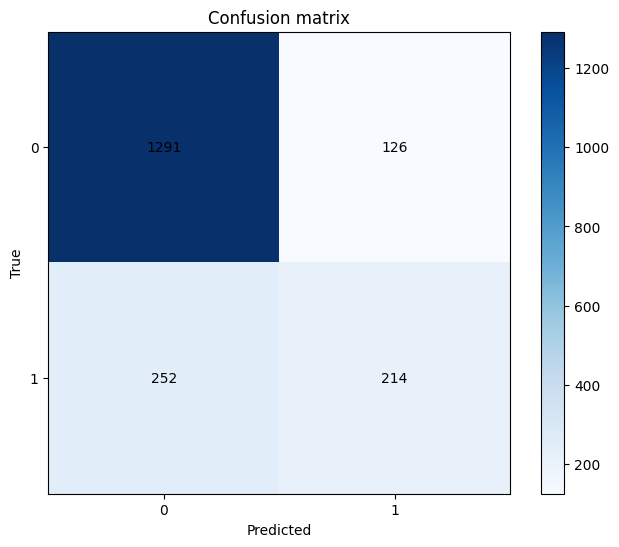

In [85]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(conf_matrix, cmap=plt.get_cmap('Blues'))
cbar = ax.figure.colorbar(im, ax=ax)

classes = dummy_adults['income_>50K'].unique()
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix")

for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, conf_matrix[i, j], ha="center", va="center", color="k")

In [86]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1417
           1       0.63      0.46      0.53       466

    accuracy                           0.80      1883
   macro avg       0.73      0.69      0.70      1883
weighted avg       0.79      0.80      0.79      1883



In [87]:
# accuracy scores
train_preds = knn_model.predict(X_train_transformed)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f'Train accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

Train accuracy: 0.84
Test accuracy: 0.80


### II
Next, experiment with different values of K (say from 5 to 100) and the weight parameter (i.e., with or without distance weighting) to see if you can improve accuracy of the KNN classifier. Show the results in a single plot comparing distance and uniform weighting schemes across the different values of K. Use the best values of these parameter (K and weighting scheme) to train a new KNN classifier and report the accuracy of this classifier on the training and test sets.

In [88]:
# define weight parameter
weight_param = ['distance', 'uniform']
distance_acc, uniform_acc = [], []

for weight in weight_param:
  for k_value in range(5, 101, 5):
    knn_model = KNeighborsClassifier(n_neighbors=k_value, weights=weight)
    knn_model.fit(X_train_transformed, y_train)
    test_preds = knn_model.predict(X_test_transformed)
    if weight == 'distance':
      distance_acc.append(accuracy_score(y_test, test_preds))
    else:
      uniform_acc.append(accuracy_score(y_test, test_preds))

In [90]:
len(distance_acc), len(uniform_acc)

(20, 20)

Text(0.5, 1.0, 'Classification accuracy (test) over range of k values')

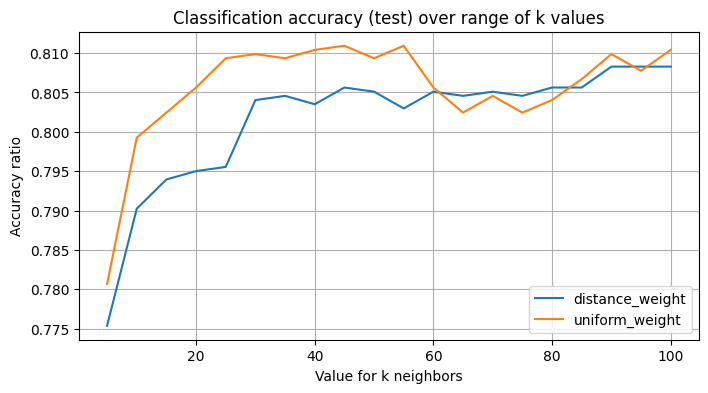

In [89]:
plt.figure(figsize=(8, 4))
plt.plot(range(5, 101, 5), distance_acc, label='distance_weight')
plt.plot(range(5, 101, 5), uniform_acc, label='uniform_weight')
plt.legend()
plt.grid()
plt.xlabel("Value for k neighbors")
plt.ylabel("Accuracy ratio")
plt.title("Classification accuracy (test) over range of k values")

K = 45 with uniform weight has the highest accuracy so we'll build a new model using these parameters.

In [91]:
# best model parameters
params = {'n_neighbors':45, 'weights':'uniform'}

In [92]:
best_knn_model = KNeighborsClassifier(**params)

In [93]:
best_knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 45,
 'p': 2,
 'weights': 'uniform'}

In [94]:
# train model
best_knn_model.fit(X_train_transformed, y_train)

KNeighborsClassifier(n_neighbors=45)

In [95]:
# predict
train_preds = best_knn_model.predict(X_train_transformed)
test_preds = best_knn_model.predict(X_test_transformed)

In [96]:
print(f'Train accuracy: {accuracy_score(y_train, train_preds):.2f}')
print(f'Test accuracy: {accuracy_score(y_test, test_preds):.2f}')

Train accuracy: 0.82
Test accuracy: 0.81


In [97]:
print('Classification report: Train')
print(classification_report(y_train, train_preds))
print('\n')
print('Classification report: Test')
print(classification_report(y_test, test_preds))

Classification report: Train
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      5676
           1       0.67      0.52      0.58      1853

    accuracy                           0.82      7529
   macro avg       0.76      0.72      0.73      7529
weighted avg       0.81      0.82      0.81      7529



Classification report: Test
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1417
           1       0.66      0.48      0.56       466

    accuracy                           0.81      1883
   macro avg       0.75      0.70      0.72      1883
weighted avg       0.80      0.81      0.80      1883



### III.
iii.	Next, using only "uniform" weights, compare the accuracy of the KNN classifier across the different values of K on the training and the test data. You should show the results in a single figure with two line plots for the test and training accuracy values (y-axis) and with values of K in the x-axis. What range of values of K represent overfitting? Briefly explain.

In [98]:
# define params
weight = 'uniform'

train_acc, test_acc = [], []

for k_val in range(5, 101, 5):
  knn_model = KNeighborsClassifier(weights=weight, n_neighbors=k_val)
  knn_model.fit(X_train_transformed, y_train)

  # predict
  train_preds = knn_model.predict(X_train_transformed)
  test_preds = knn_model.predict(X_test_transformed)

  # get accuracy scores
  train_acc.append(accuracy_score(y_train, train_preds))
  test_acc.append(accuracy_score(y_test, test_preds))

Text(0.5, 1.0, 'Accuracy score over range of k values')

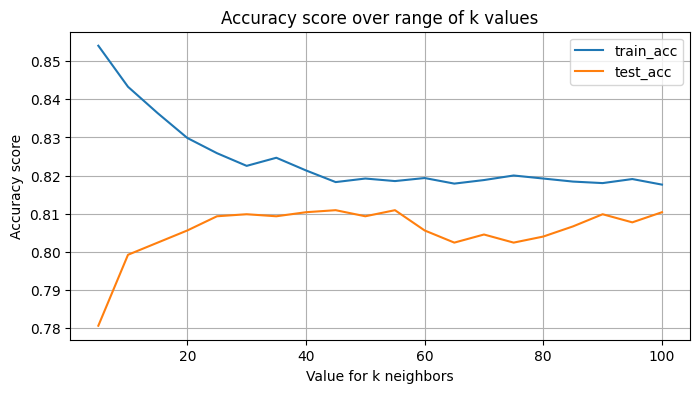

In [99]:
plt.figure(figsize=(8, 4))
plt.plot(range(5, 101, 5), train_acc, label='train_acc')
plt.plot(range(5, 101, 5), test_acc, label='test_acc')
plt.legend()
plt.grid()
plt.xlabel("Value for k neighbors")
plt.ylabel("Accuracy score")
plt.title("Accuracy score over range of k values")

In the plot above of train and test accuracy over values of K, we see a large gap in train and test accuracy in the range of K values till 20. This means that model accuracy can be improved by further increasing k value.

Further K=20, the model seems to be generalizing when we increase K value until K=50. As we increase K value further, the train accuracy remains constant while test accuracy drops. This is sign that the model is fitting the training data set too closely, leading to poor generalization to test cases.

## c.
Using the non-normalized training and test data, perform classification using scikit-learn's decision tree classifier (using the default parameters). As above, generate the confusion matrix, classification report, and average accuracy scores of the classifier. Compare the average accuracy score on the test and the training data sets. What does the comparison tell you in terms of bias-variance trade-off? Next, create another decision tree model (trained on the non-normalized training data) using "gini" index as the selection criteria, min_samples_split=10, and max_depth=4. Show the accuracy results for both the training and test sets. For this model generate a visualization of tree embedded in the Jupyter Notebook.

In [100]:
# import methods
from sklearn.tree import DecisionTreeClassifier

In [101]:
## initiate the model
dtree_model = DecisionTreeClassifier(random_state = RANDOM_STATE)

In [102]:
# train model
dtree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=111)

In [103]:
# predict
train_preds = dtree_model.predict(X_train)
test_preds = dtree_model.predict(X_test)

In [104]:
# accuracy scores
print(f"Train accuracy : {accuracy_score(y_train, train_preds):.2f}")
print(f"Test accuracy : {accuracy_score(y_test, test_preds):.2f}")

Train accuracy : 0.94
Test accuracy : 0.75


In [105]:
print('Classification report: Train')
print(classification_report(y_train, train_preds))
print('\n')
print('Classification report: Test')
print(classification_report(y_test, test_preds))

Classification report: Train
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5676
           1       0.95      0.81      0.88      1853

    accuracy                           0.94      7529
   macro avg       0.95      0.90      0.92      7529
weighted avg       0.94      0.94      0.94      7529



Classification report: Test
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1417
           1       0.49      0.45      0.47       466

    accuracy                           0.75      1883
   macro avg       0.66      0.65      0.65      1883
weighted avg       0.74      0.75      0.74      1883



Training accuracy is higher in this case, which can mean the decision tree model is likely overfitting the training data, leading to a high-variance model.

Test accuracy is comparatively low. Since the model is overfitting, it might be capturing noise and hence low accuracy is seen on unseen data.

In [106]:
# tuned model
tree_params = {'criterion':'gini', 'min_samples_split':10, 'max_depth':10}
tuned_dtree_model = DecisionTreeClassifier(**tree_params, random_state=RANDOM_STATE)

In [107]:
tuned_dtree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 111,
 'splitter': 'best'}

In [108]:
# fit model
tuned_dtree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=111)

In [109]:
# predict using model
train_preds = tuned_dtree_model.predict(X_train)
test_preds = tuned_dtree_model.predict(X_test)

In [110]:
# accuracy scores
print(f"Train accuracy : {accuracy_score(y_train, train_preds):.2f}")
print(f"Test accuracy : {accuracy_score(y_test, test_preds):.2f}")

Train accuracy : 0.84
Test accuracy : 0.80


In [111]:
print('Classification report: Train')
print(classification_report(y_train, train_preds))
print('\n')
print('Classification report: Test')
print(classification_report(y_test, test_preds))

Classification report: Train
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5676
           1       0.74      0.57      0.64      1853

    accuracy                           0.84      7529
   macro avg       0.80      0.75      0.77      7529
weighted avg       0.84      0.84      0.84      7529



Classification report: Test
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1417
           1       0.64      0.48      0.55       466

    accuracy                           0.80      1883
   macro avg       0.74      0.69      0.71      1883
weighted avg       0.79      0.80      0.79      1883



This version of model is more accurate than previous model with default parameters.

This shows that some level of hyperparameter tuning can lead to improvement in model performance.

In [112]:
# plot the tree in notebook
from sklearn.tree import plot_tree

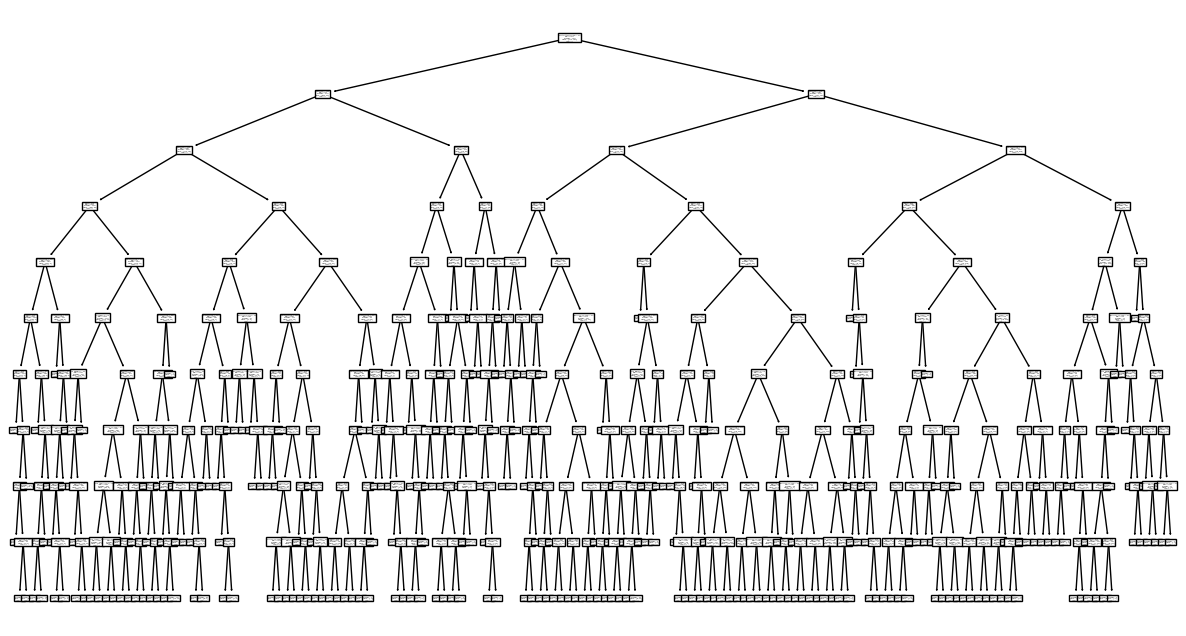

In [113]:
plt.figure(figsize=(15, 8))
plot_tree(tuned_dtree_model, feature_names=X_train.columns, class_names=['0', '1'], )
plt.show()

## d.
Use scikit-learn to build classifiers using Naive Bayes (Gaussian) and linear discriminant analysis (LDA).  For each of these perform 10-fold cross-validation on the 80% training data (using cross-validation module in scikit-learn) and report the overall average accuracy. Compare this cross-validation accuracy to the model accuracy on the training data as a whole. Finally, run your model on the set-aside 20% test data.

In [114]:
# import methods
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate

In [115]:
# initiate models
nb_model = GaussianNB()
lda_model = LinearDiscriminantAnalysis()

In [116]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE)

In [117]:
# cross-validate
nb_cv_results = cross_validate(nb_model, X_train, y_train, cv=10)
lda_cv_results = cross_validate(lda_model, X_train, y_train, cv=10)

In [118]:
len(nb_cv_results), len(lda_cv_results)

(3, 3)

In [119]:
nb_cv_results

{'fit_time': array([0.01054263, 0.01733136, 0.00799394, 0.00686431, 0.00679851,
        0.00685072, 0.00698376, 0.00701761, 0.00680327, 0.00710034]),
 'score_time': array([0.00298834, 0.00308347, 0.00283742, 0.00272751, 0.00271964,
        0.00269413, 0.00266647, 0.00273132, 0.0026226 , 0.00260544]),
 'test_score': array([0.71713147, 0.71049137, 0.73041169, 0.68924303, 0.74236388,
        0.73572377, 0.7065073 , 0.71447543, 0.71181939, 0.73537234])}

In [120]:
nb_avg_cv_acc = nb_cv_results['test_score'].mean()
lda_avg_cv_acc = lda_cv_results['test_score'].mean()

In [121]:
print(f'Average accuracy score: Naive Bayes: {nb_avg_cv_acc:.2f}')
print(f'Average accuracy score: LDA: {lda_avg_cv_acc:.2f}')

Average accuracy score: Naive Bayes: 0.72
Average accuracy score: LDA: 0.81


Text(0.5, 1.0, 'Cross validation score over folds (training)')

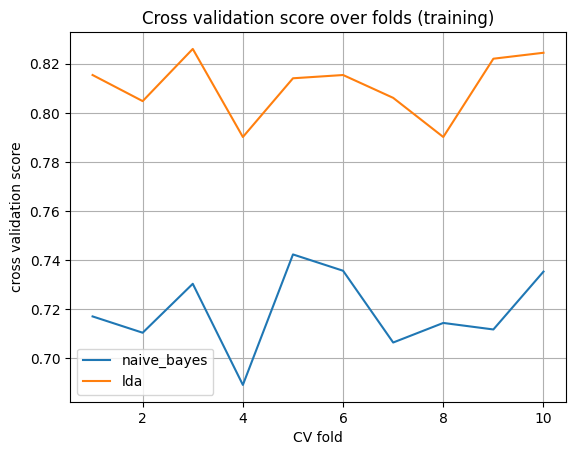

In [122]:
plt.plot(range(1, 11, 1), nb_cv_results['test_score'], label='naive_bayes')
plt.plot(range(1, 11, 1), lda_cv_results['test_score'], label='lda')
plt.legend()
plt.grid()
plt.xlabel('CV fold')
plt.ylabel('cross validation score')
plt.title('Cross validation score over folds (training)')

In [123]:
# fit models
nb_model.fit(X_train, y_train)

GaussianNB()

In [124]:
# fit model
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [125]:
# run over test data
nb_test_preds = nb_model.predict(X_test)
lda_test_preds = lda_model.predict(X_test)

In [126]:
# accuracy scores
print(f"Naive bayes test accuracy : {accuracy_score(y_test, nb_test_preds):.2f}")
print(f"LDA test accuracy : {accuracy_score(y_test, lda_test_preds):.2f}")

Naive bayes test accuracy : 0.71
LDA test accuracy : 0.80


In [127]:
print('Classification report: Naive Bayes')
print(classification_report(y_test, nb_test_preds))
print('\n')
print('Classification report: LDA Model')
print(classification_report(y_test, lda_test_preds))

Classification report: Naive Bayes
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1417
           1       0.45      0.74      0.56       466

    accuracy                           0.71      1883
   macro avg       0.67      0.72      0.67      1883
weighted avg       0.78      0.71      0.73      1883



Classification report: LDA Model
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1417
           1       0.63      0.46      0.53       466

    accuracy                           0.80      1883
   macro avg       0.73      0.69      0.70      1883
weighted avg       0.79      0.80      0.79      1883



Overall accuracy of LDA model is high compared to Naive Bayes.

However, if we consider precision-recall, Naive Bayes model has good recall for class 1, while LDA model has high recall for class 0.